#UFO DATA EXPLORATION

In [1]:
from datetime import timedelta

In [2]:
%%time
#raw_data = pd.read_csv('./data/complete.csv')
scrubbed_data = pd.read_csv('./data/scrubbed.csv', low_memory=False)

CPU times: user 239 ms, sys: 31.1 ms, total: 270 ms
Wall time: 348 ms


In [3]:
scrubbed_data.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611


In [4]:
import seaborn as sns
plt.style.use('dark_background')
plt.rcParams['font.size'] = 14
plt.figure(figsize=(12,5))
palette = sns.color_palette('Paired', 10)

<Figure size 864x360 with 0 Axes>

In [5]:
scrubbed_data['country'].describe()

count     70662
unique        5
top          us
freq      65114
Name: country, dtype: object

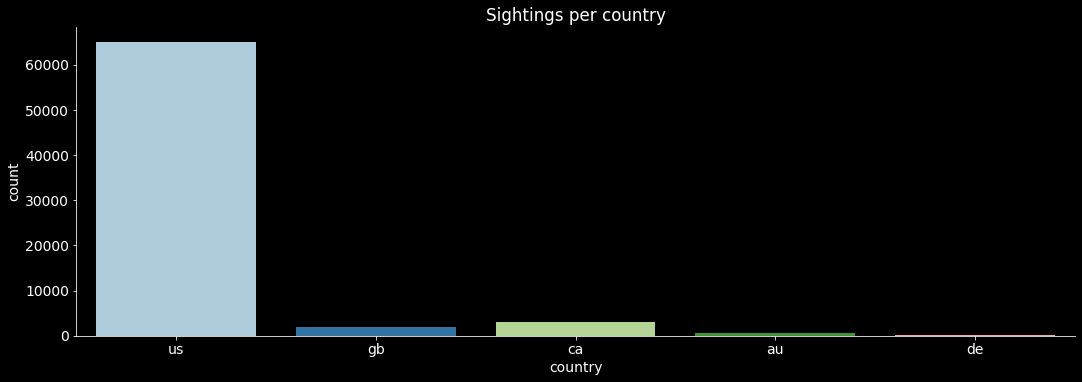

In [6]:
sns.catplot(x="country", kind="count", palette=palette, data=scrubbed_data, height=5, aspect=3);
sns.despine()
plt.title('Sightings per country');
plt.show()

In [7]:
def extract_time_features(df):
    timezone_name = 'America/New_York'
    time_column = "datetime"
    df['datetime_zero'] = df[time_column].str.replace('24:00', '0:00')
    df['datetime_er'] = pd.to_datetime(df['datetime_zero'], format='%m/%d/%Y %H:%M')
    selrow = df['datetime'].str.contains('24:00')
    df[time_column] = df['datetime_er'] + selrow * timedelta(days=1)
    df.index = pd.to_datetime(df[time_column])
    df["dow"] = df.index.weekday
    df["hour"] = df.index.hour
    df["month"] = df.index.month
    df["year"] = df.index.year
    return df.reset_index(drop=True)

In [8]:
time_df = extract_time_features(scrubbed_data)

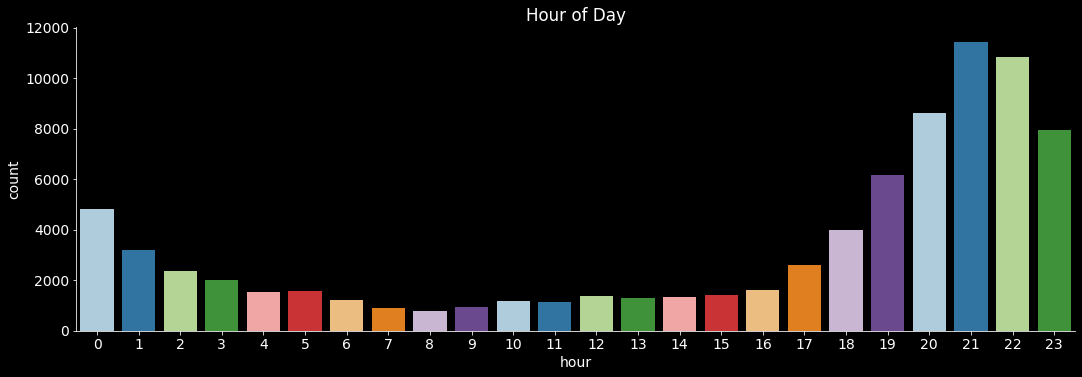

In [9]:
sns.catplot(x="hour", kind="count", palette=palette, data=time_df, height=5, aspect=3);
sns.despine()
plt.title('Hour of Day');
plt.show()

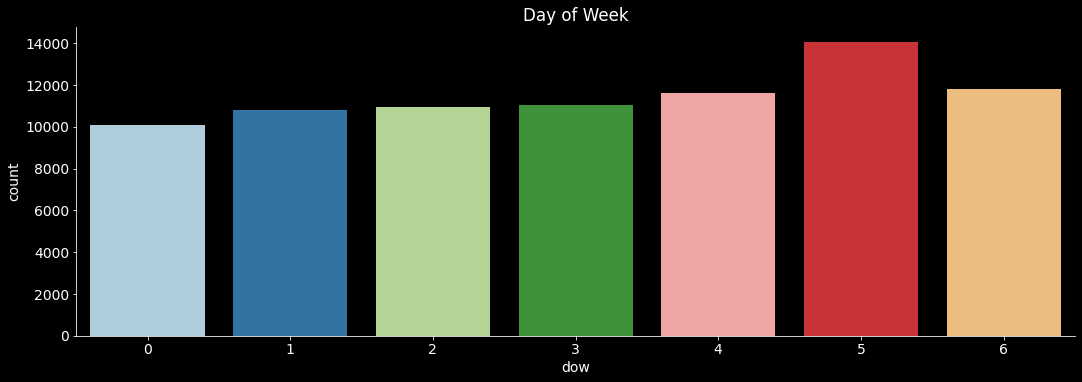

In [12]:
sns.catplot(x="dow", kind="count", palette=palette, data=time_df, height=5, aspect=3);
sns.despine()
plt.title('Day of Week');
plt.show()

In [13]:
import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime

In [14]:
center_location = 29.8830556, -97.9411111
m = folium.Map(location=center_location, control_scale=True, zoom_start=3)

In [20]:
location_df = scrubbed_data[['latitude',
                             'longitude ']]

In [21]:
location_df['count'] = 1
heatmap_data = location_df.head(10000).groupby(['latitude', 'longitude ']).sum().reset_index().values.tolist()
gradient = {0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}
HeatMap(data=heatmap_data, radius=5, gradient=gradient, max_zoom=13).add_to(m)
m

<ipython-input-21-79c7aafa0fac>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_df['count'] = 1


In [24]:
time_df['count'] = 1
heatmap_data_by_hour = []
__df__ = time_df.head(10000)
for hour in time_df.hour.sort_values().unique():
    _df = __df__[__df__.hour == hour][['longitude ', 'latitude', 'count']].groupby(['latitude', 'longitude ']).sum().reset_index().values.tolist()
    heatmap_data_by_hour.append(_df)

In [25]:
m2 = folium.Map(location=center_location, control_scale=True, zoom_start=11)
HeatMapWithTime(heatmap_data_by_hour, radius=5, 
                gradient=gradient, 
                min_opacity=0.5, max_opacity=0.8, 
                use_local_extrema=False).add_to(m2)
m2